SST2

In [1]:
!pip install datasets --quiet

     |████████████████████████████████| 325 kB 4.1 MB/s 
     |████████████████████████████████| 67 kB 3.5 MB/s 
     |████████████████████████████████| 134 kB 50.1 MB/s 
     |████████████████████████████████| 212 kB 47.5 MB/s 
     |████████████████████████████████| 1.1 MB 43.3 MB/s 
     |████████████████████████████████| 127 kB 52.1 MB/s 
     |████████████████████████████████| 271 kB 25.1 MB/s 
     |████████████████████████████████| 144 kB 22.1 MB/s 
     |████████████████████████████████| 94 kB 3.0 MB/s 
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
datascience 0.10.6 requires folium==0.2.1, but you have folium 0.8.3 which is incompatible.


In [ ]:
from datasets import load_dataset
dataset = load_dataset('glue', 'sst2')

Generating train split:   0%|          | 0/67349 [00:00<?, ? examples/s]

Generating validation split:   0%|          | 0/872 [00:00<?, ? examples/s]

Generating test split:   0%|          | 0/1821 [00:00<?, ? examples/s]

Dataset glue downloaded and prepared to /root/.cache/huggingface/datasets/glue/sst2/1.0.0/dacbe3125aa31d7f70367a07a8a9e72a5a0bfeb5fc42e75c9db75b96da6053ad. Subsequent calls will reuse this data.


  0%|          | 0/3 [00:00<?, ?it/s]

In [ ]:
dataset

DatasetDict({
    train: Dataset({
        features: ['sentence', 'label', 'idx'],
        num_rows: 67349
    })
    validation: Dataset({
        features: ['sentence', 'label', 'idx'],
        num_rows: 872
    })
    test: Dataset({
        features: ['sentence', 'label', 'idx'],
        num_rows: 1821
    })
})

In [ ]:
dataset['train']['sentence'][:10]

['hide new secretions from the parental units ',
 'contains no wit , only labored gags ',
 'that loves its characters and communicates something rather beautiful about human nature ',
 'remains utterly satisfied to remain the same throughout ',
 'on the worst revenge-of-the-nerds clichés the filmmakers could dredge up ',
 "that 's far too tragic to merit such superficial treatment ",
 'demonstrates that the director of such hollywood blockbusters as patriot games can still turn out a small , personal film with an emotional wallop . ',
 'of saucy ',
 "a depressed fifteen-year-old 's suicidal poetry ",
 "are more deeply thought through than in most ` right-thinking ' films "]

In [4]:
import torch

In [5]:
device = "cuda" if torch.cuda.is_available() else "cpu"
device

'cuda'

In [6]:
!pip install transformers --quiet

     |████████████████████████████████| 3.8 MB 4.3 MB/s 
     |████████████████████████████████| 6.5 MB 22.2 MB/s 
     |████████████████████████████████| 596 kB 50.6 MB/s 
     |████████████████████████████████| 895 kB 50.8 MB/s 


In [ ]:
from torch.utils.data import DataLoader

train_dataloader = DataLoader(dataset['train'], batch_size=64, shuffle=False)
val_dataloader = DataLoader(dataset['validation'], batch_size=64, shuffle=False)

In [ ]:
from transformers import BertTokenizer # https://huggingface.co/docs/transformers/tokenizer_summary

tokenizer = BertTokenizer.from_pretrained("bert-base-uncased")

Downloading:   0%|          | 0.00/226k [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/28.0 [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/570 [00:00<?, ?B/s]

In [ ]:
import string
import nltk

In [ ]:
from nltk.corpus import stopwords
import re

stopWords = set(stopwords.words('english'))

wnl = nltk.WordNetLemmatizer()

def preproc_nltk(text):
    return " ".join([wnl.lemmatize(word) for word in word_tokenize(text.lower()) if word not in stopWords])

st = "don't hide new secretions from the parental units "
preproc_nltk('revenge-of-the-nerds')

'revenge-of-the-nerds'

In [ ]:
import gensim.downloader

embeddings_pretrained = gensim.downloader.load('glove-twitter-50')

[==================================================] 100.0% 199.5/199.5MB downloaded


In [ ]:
!pip install fasttext

In [ ]:
import fasttext.util
fasttext.util.download_model('en', if_exists='ignore')  # English
embeddings_pretrained = fasttext.load_model('cc.en.300.bin')

In [ ]:
len(embeddings_pretrained.get_sentence_vector(st))

300

In [ ]:
from nltk.tokenize import word_tokenize, sent_tokenize
import numpy as np

test_dataset = dataset['test']

embeddings = []

for data in test_dataset:
    sent, label = data['sentence'], data['label']

    sent = preproc_nltk(sent)

    emb = embeddings_pretrained.get_sentence_vector(sent)

    embeddings.append(emb)

test_dataset = test_dataset.add_column('embedding', embeddings)

In [ ]:
from datasets.dataset_dict import DatasetDict

dataset = DatasetDict({'train': train_dataset, 'validation': val_dataset, 'test': test_dataset})

In [ ]:
dataset.save_to_disk('/content/drive/MyDrive/sst2')

In [2]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [9]:
from datasets import load_from_disk

dataset = load_from_disk('/content/drive/MyDrive/sst2')

In [12]:
dataset

DatasetDict({
    train: Dataset({
        features: ['sentence', 'label', 'idx', 'embedding'],
        num_rows: 67349
    })
    validation: Dataset({
        features: ['sentence', 'label', 'idx', 'embedding'],
        num_rows: 872
    })
    test: Dataset({
        features: ['sentence', 'label', 'idx', 'embedding'],
        num_rows: 1821
    })
})

In [134]:
from torch.utils.data import DataLoader

batch_size = 32

train_loader = DataLoader(dataset['train'], batch_size=batch_size)
val_loader = DataLoader(dataset['validation'], batch_size=batch_size)
test_loader = DataLoader(dataset['test'], batch_size=batch_size)

In [63]:
import torch.nn as nn

in_dim = 300
out_dim = 2
p = 0.2

model = nn.Sequential(
    nn.Linear(in_dim, 512),
    nn.BatchNorm1d(512),
    nn.ReLU(),
    nn.Dropout(p),

    nn.Linear(512, 512),
    nn.BatchNorm1d(512),
    nn.ReLU(),
    nn.Dropout(p),

    nn.Linear(512, 256),
    nn.BatchNorm1d(256),
    nn.ReLU(),
    nn.Dropout(p),

    nn.Linear(256, out_dim)
).to(device)

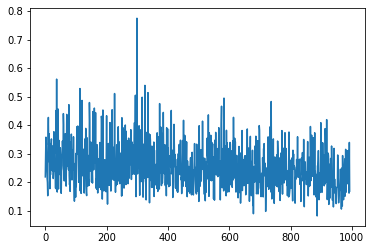

100%|██████████| 1053/1053 [00:47<00:00, 22.19it/s]


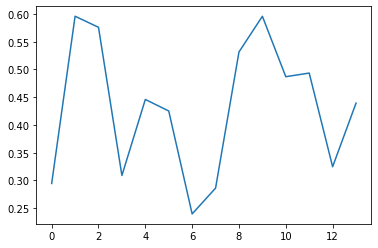

In [64]:
## batch_size = 64

import torch.optim as optim

from tqdm import tqdm
from IPython.display import clear_output
import matplotlib.pyplot as plt

num_epochs = 3
i = 0

criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=1e-3)
scheduler = optim.lr_scheduler.StepLR(optimizer, gamma=0.1, step_size=1)


for epoch in range(num_epochs):
    train_losses = []
    val_losses = []

    model.train()
    for data in tqdm(train_loader):
        emb = torch.stack(data['embedding']).to(torch.float).to(device).t()
        labels = data['label'].to(device)

        outputs = model(emb)
      
        loss = criterion(outputs, labels)
        train_losses.append(loss.item())

        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        i += 1

        if i % 100 == 0:
            clear_output()
            plt.plot(train_losses)
            plt.show()
  
    scheduler.step()

    model.eval()
    with torch.no_grad():
        for data in val_loader:
            emb = torch.stack(data['embedding']).to(torch.float).to(device).t()
            labels = data['label'].to(device)

            outputs = model(emb)
          
            loss = criterion(outputs, labels)
            val_losses.append(loss.item())
    plt.plot(val_losses)
    plt.show()

In [78]:
from sklearn.metrics import f1_score

preds = []
correct = []

model.eval()
with torch.no_grad():
    for data in val_loader:
        emb = torch.stack(data['embedding']).to(torch.float).to(device).t()
        labels = data['label'].to(device)

        outputs = model(emb)

        preds += outputs.argmax(axis=1)
        correct += labels

correct = torch.tensor(correct).cpu()
preds = torch.tensor(preds).cpu()

print('Accuracy:', (correct == preds).to(torch.float).mean().item())
print('F1 score:', f1_score(correct, preds))

Accuracy: 0.8142201900482178
F1 score: 0.8219780219780218


Roberta

In [136]:
from transformers import RobertaTokenizer, RobertaConfig, RobertaModel
import torch.nn as nn

tokenizer = RobertaTokenizer.from_pretrained("roberta-large-mnli")
model = RobertaModel.from_pretrained("roberta-large-mnli")

torch.manual_seed(42)

for param in model.embeddings.parameters():
    param.requires_grad = False

i = 0
for child in model.encoder.layer.children():
    if i > 15:
        break
    i += 1
    for param in child.parameters():
        param.requires_grad = False
    

model.pooler = nn.Sequential(
    nn.Linear(1024, 256),
    nn.LayerNorm(256),
    nn.ReLU(),
    nn.Linear(256, 2)
)

model = model.to(device)

Some weights of the model checkpoint at roberta-large-mnli were not used when initializing RobertaModel: ['classifier.dense.weight', 'classifier.dense.bias', 'classifier.out_proj.weight', 'classifier.out_proj.bias']
- This IS expected if you are initializing RobertaModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing RobertaModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).


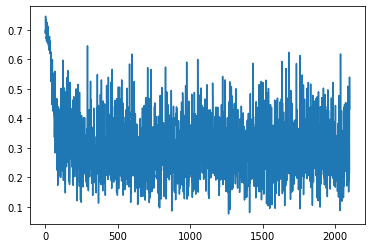

100%|██████████| 2105/2105 [31:07<00:00,  1.13it/s]


In [139]:
## batch_size = 32

num_epochs = 1

criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=4e-6)
scheduler = optim.lr_scheduler.StepLR(optimizer, gamma=0.5, step_size=50)

i = 0
for epoch in range(num_epochs):
    train_losses = []
    val_losses = []

    model.train()
    for data in tqdm(train_loader):
        text = data['sentence']
        encoded_input = tokenizer(text, return_tensors='pt', padding=True, 
                                  max_length = 128, truncation=True).to(device)
        labels = data['label'].to(device)

        outputs = model(**encoded_input).pooler_output[:, 0, :]

        loss = criterion(outputs, labels)
        train_losses.append(loss.item())

        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        i += 1
        scheduler.step()

        if i % 10 == 0:
            clear_output()
            plt.plot(train_losses)
            plt.show()

In [140]:
preds = []
correct = []

model.eval()
with torch.no_grad():
    for data in val_loader:
        text = data['sentence']
        encoded_input = tokenizer(text, return_tensors='pt', padding=True, 
                              max_length = 128, truncation=True).to(device)

        labels = data['label'].to(device)

        outputs = model(**encoded_input).pooler_output[:, 0, :]


        preds += outputs.argmax(axis=1)
        correct += labels

correct = torch.tensor(correct).cpu()
preds = torch.tensor(preds).cpu()

print('Accuracy:', (correct == preds).to(torch.float).mean().item())
print('F1 score:', f1_score(correct, preds))

Accuracy: 0.8933486342430115
F1 score: 0.892485549132948
